##Kaggle Predict Future Sales:

###Introduction


In this competition you are provided with a challenging time-series dataset consisting of daily sales data, kindly provided by one of the largest Russian software firms - 1C Company. We are asking you to predict total sales for every product and store in the next month. The task is to forecast the total amount of products sold in every shop for the test set. Note that the list of shops and products changes every month. Creating a unique and robust model that can handle such situations is part of the challenge. By solving this competition you will be able to apply and enhance your data science skills.

This notebook contains general information about the methods using which you can approach the problem statement. 


Lets first discuss what we are given and what we have to predict.
About our dataset:

The features in our training data :- 
1. date - every date of items sold
2. date_block_num - this number is given to every month
3. shop_id - unique number of every shop
4. item_id - unique number of every item
5. item_price - price of every item
6. item_cnt_day - number of items sold on a particular day 

The features in our testing data :- 
1. ID - unique for every (shop_id,item_id) pair.
2. shop_id - unique number of every shop
3. item_id - unique number of every item

Daily historical sales are given from Jan 2013 to Oct 2015. The task is to predict total sales for every product and store in the next month. 
The goal is here to minimise the performance metric: RMSE score.

Our submission should have ID and item_cnt_month columns.

Approach: 
1. Exploratory Data Analysis


**NOTE**: To get further your understanding and get an even better idea of the concepts used in the notebook, we strongly recommend you to check out the 'How to Win a Data Science Competition' course. 

###Part 1: Exploratory Data Analysis with the Dataset

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import warnings
from xgboost import XGBRegressor
from xgboost import plot_importance
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Datasets apart from the test and train dataset that are given to us:
1. item_categories.csv - has the item category name along with the category ID
2. items.csv - has the item name along with item ID and category ID
3. shops.csv - has the shop name along with shop ID

In [ ]:
categories = pd.read_csv('/content/drive/MyDrive/competitive-data-science-predict-future-sales/item_categories.csv')
items = pd.read_csv('/content/drive/MyDrive/competitive-data-science-predict-future-sales/items.csv')
train = pd.read_csv('/content/drive/MyDrive/competitive-data-science-predict-future-sales/sales_train.csv')
shops = pd.read_csv('/content/drive/MyDrive/competitive-data-science-predict-future-sales/shops.csv')
test = pd.read_csv('/content/drive/MyDrive/competitive-data-science-predict-future-sales/test.csv')

###1. Categories :

In [ ]:
print("First 5 Entries")
print(categories.head(5))

print("Information")
print(categories.info())

print("Data Types")
print(categories.dtypes)

print("Missing Value")
print(categories.isnull().sum())

print("Null Value")
print(categories.isna().sum())

print("Shape")
print(categories.shape)

First 5 Entries
        item_category_name  item_category_id
0  PC - Гарнитуры/Наушники                 0
1         Аксессуары - PS2                 1
2         Аксессуары - PS3                 2
3         Аксессуары - PS4                 3
4         Аксессуары - PSP                 4
Information
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84 entries, 0 to 83
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   item_category_name  84 non-null     object
 1   item_category_id    84 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.4+ KB
None
Data Types
item_category_name    object
item_category_id       int64
dtype: object
Missing Value
item_category_name    0
item_category_id      0
dtype: int64
Null Value
item_category_name    0
item_category_id      0
dtype: int64
Shape
(84, 2)


In [ ]:
categories.describe()

,item_category_id
count,84.000000
mean,41.500000
std,24.392622
min,0.000000
25%,20.750000
50%,41.500000
75%,62.250000
max,83.000000


###2. Items

In [ ]:
print("First 5 Entries")
print(items.head(5))

print("Information")
print(items.info())

print("Data Types")
print(items.dtypes)

print("Missing value")
print(items.isnull().sum())

print("Null value")
print(items.isna().sum())

print("Shape of Data")
print(items.shape)

First 5 Entries
                                           item_name  item_id  item_category_id
0          ! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.)         D        0                40
1  !ABBYY FineReader 12 Professional Edition Full...        1                76
2      ***В ЛУЧАХ СЛАВЫ   (UNV)                    D        2                40
3    ***ГОЛУБАЯ ВОЛНА  (Univ)                      D        3                40
4        ***КОРОБКА (СТЕКЛО)                       D        4                40
Information
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22170 entries, 0 to 22169
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   item_name         22170 non-null  object
 1   item_id           22170 non-null  int64 
 2   item_category_id  22170 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 519.7+ KB
None
Data Types
item_name           object
item_id              int64
item_category_id     int64
dtype

In [ ]:
items.describe()

,item_id,item_category_id
count,22170.00000,22170.000000
mean,11084.50000,46.290753
std,6400.07207,15.941486
min,0.00000,0.000000
25%,5542.25000,37.000000
50%,11084.50000,40.000000
75%,16626.75000,58.000000
max,22169.00000,83.000000


###3. Shops

In [ ]:
print("First 5 Entries")
print(shops.head(5))

print("Info")
print(shops.info())

print("Data Types")
print(shops.dtypes)

print("Missing value")
print(shops.isnull().sum())

print("Null value")
print(shops.isna().sum())

print("Shape of Data")
print(shops.shape)

First 5 Entries
                        shop_name  shop_id
0   !Якутск Орджоникидзе, 56 фран        0
1   !Якутск ТЦ "Центральный" фран        1
2                Адыгея ТЦ "Мега"        2
3  Балашиха ТРК "Октябрь-Киномир"        3
4        Волжский ТЦ "Волга Молл"        4
Info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   shop_name  60 non-null     object
 1   shop_id    60 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.1+ KB
None
Data Types
shop_name    object
shop_id       int64
dtype: object
Missing value
shop_name    0
shop_id      0
dtype: int64
Null value
shop_name    0
shop_id      0
dtype: int64
Shape of Data
(60, 2)


###4. Train

In [ ]:
print("First 5 entries")
print(train.head())


First 5 entries
         date  date_block_num  shop_id  item_id  item_price  item_cnt_day
0  02.01.2013               0       59    22154      999.00           1.0
1  03.01.2013               0       25     2552      899.00           1.0
2  05.01.2013               0       25     2552      899.00          -1.0
3  06.01.2013               0       25     2554     1709.05           1.0
4  15.01.2013               0       25     2555     1099.00           1.0


In [ ]:
print("Shape")
print(train.shape)

Shape
(2935849, 6)


In [ ]:
print("Data Info")
print(train.info())

Data Info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype  
---  ------          -----  
 0   date            object 
 1   date_block_num  int64  
 2   shop_id         int64  
 3   item_id         int64  
 4   item_price      float64
 5   item_cnt_day    float64
dtypes: float64(2), int64(3), object(1)
memory usage: 134.4+ MB
None


In [ ]:
print("Data Types")
print(train.dtypes)

Data Types
date               object
date_block_num      int64
shop_id             int64
item_id             int64
item_price        float64
item_cnt_day      float64
dtype: object


In [ ]:
print("Missing NaN values")
print(train.isnull().sum())

Missing NaN values
date              0
date_block_num    0
shop_id           0
item_id           0
item_price        0
item_cnt_day      0
dtype: int64


In [ ]:
print("Null Values")
print(train.isna().sum())

Null Values
date              0
date_block_num    0
shop_id           0
item_id           0
item_price        0
item_cnt_day      0
dtype: int64


In [ ]:
train.describe()

,date_block_num,shop_id,item_id,item_price,item_cnt_day
count,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06
mean,1.456991e+01,3.300173e+01,1.019723e+04,8.908532e+02,1.242641e+00
std,9.422988e+00,1.622697e+01,6.324297e+03,1.729800e+03,2.618834e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,-2.200000e+01
25%,7.000000e+00,2.200000e+01,4.476000e+03,2.490000e+02,1.000000e+00
50%,1.400000e+01,3.100000e+01,9.343000e+03,3.990000e+02,1.000000e+00
75%,2.300000e+01,4.700000e+01,1.568400e+04,9.990000e+02,1.000000e+00
max,3.300000e+01,5.900000e+01,2.216900e+04,3.079800e+05,2.169000e+03


In [ ]:
train['date'] = pd.to_datetime(train['date'], format = '%d.%m.%Y')
train

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,2013-01-02,0,59,22154,999.00,1.0
1,2013-01-03,0,25,2552,899.00,1.0
2,2013-01-05,0,25,2552,899.00,-1.0
3,2013-01-06,0,25,2554,1709.05,1.0
4,2013-01-15,0,25,2555,1099.00,1.0
...,...,...,...,...,...,...
2935844,2015-10-10,33,25,7409,299.00,1.0
2935845,2015-10-09,33,25,7460,299.00,1.0
2935846,2015-10-14,33,25,7459,349.00,1.0
2935847,2015-10-22,33,25,7440,299.00,1.0


You can repeat a similar kind of analysis for test dataset too. 

Joining the datasets: like we're adding more features from the other datasets given to us to the train set in order to analyse it better and make accurate predictions

In [ ]:
train = train.join(items, on='item_id', rsuffix='_').join(shops, on='shop_id', rsuffix='_').join(categories, on='item_category_id', rsuffix='_').drop(['item_id_', 'shop_id_', 'item_category_id_'], axis=1)

Let's take a look at the raw data.

In [ ]:
print('Train rows: ', train.shape[0])
print('Train columns: ', train.shape[1])

Train rows:  2935849
Train columns:  10


Time period of the dataset:

In [ ]:
print('Min date from train set: %s' % train['date'].min().date())
print('Max date from train set: %s' % train['date'].max().date())

Min date from train set: 2013-01-01
Max date from train set: 2015-10-31


So, basically we're looking at a window of 34 months, and also we can observe that based on the same date_block_num column has assigned values from 0 to 33.

Now, let's drop the duplicate rows, if any, retaining the row that comes first.

In [ ]:
#Note that this function can be modified by choosing to calculate duplicates over only a subset of features, keeping the last entry, etc.
train.drop_duplicates(inplace=True,keep='first')
print(train)

              date  ...                   item_category_name
0       2013-01-02  ...                       Кино - Blu-Ray
1       2013-01-03  ...                       Музыка - Винил
2       2013-01-05  ...                       Музыка - Винил
3       2013-01-06  ...                       Музыка - Винил
4       2013-01-15  ...  Музыка - CD фирменного производства
...            ...  ...                                  ...
2935844 2015-10-10  ...  Музыка - CD локального производства
2935845 2015-10-09  ...  Музыка - CD локального производства
2935846 2015-10-14  ...  Музыка - CD локального производства
2935847 2015-10-22  ...                         Музыка - MP3
2935848 2015-10-03  ...  Музыка - CD локального производства

[2935843 rows x 10 columns]


Let's do some data cleaning and remove rows with negative item price. 

In [ ]:
train = train.query('item_price > 0') ##Data Cleaning
train

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,shop_name,item_category_name
0,2013-01-02,0,59,22154,999.00,1.0,ЯВЛЕНИЕ 2012 (BD),37,"Ярославль ТЦ ""Альтаир""",Кино - Blu-Ray
1,2013-01-03,0,25,2552,899.00,1.0,DEEP PURPLE The House Of Blue Light LP,58,"Москва ТРК ""Атриум""",Музыка - Винил
2,2013-01-05,0,25,2552,899.00,-1.0,DEEP PURPLE The House Of Blue Light LP,58,"Москва ТРК ""Атриум""",Музыка - Винил
3,2013-01-06,0,25,2554,1709.05,1.0,DEEP PURPLE Who Do You Think We Are LP,58,"Москва ТРК ""Атриум""",Музыка - Винил
4,2013-01-15,0,25,2555,1099.00,1.0,DEEP PURPLE 30 Very Best Of 2CD (Фирм.),56,"Москва ТРК ""Атриум""",Музыка - CD фирменного производства
...,...,...,...,...,...,...,...,...,...,...
2935844,2015-10-10,33,25,7409,299.00,1.0,V/A Nu Jazz Selection (digipack),55,"Москва ТРК ""Атриум""",Музыка - CD локального производства
2935845,2015-10-09,33,25,7460,299.00,1.0,V/A The Golden Jazz Collection 1 2CD,55,"Москва ТРК ""Атриум""",Музыка - CD локального производства
2935846,2015-10-14,33,25,7459,349.00,1.0,V/A The Best Of The 3 Tenors,55,"Москва ТРК ""Атриум""",Музыка - CD локального производства
2935847,2015-10-22,33,25,7440,299.00,1.0,V/A Relax Collection Planet MP3 (mp3-CD) (jewel),57,"Москва ТРК ""Атриум""",Музыка - MP3


Now, let's check if there's any data leakage. When there's data leakage in the data used for machine learning model, you will get a high train and test accuracy, implying that the model is good enough for production. It will neither underfit or overfit.

However, when implementing the machine learning model in production, it will no longer be introduced to one feature, because it is not available when you need the model’s predictions. The feature missing might even be the most important feature for determining the right class: the leaked data.

When implementing the machine learning model in production, you will see that the predictions are not reliable.

**Data Leakage**: 

We'll only be using only the "shop_id" and "item_id" that appear on the test set. The idea here is that we know on which shops and items we are going to predict, because of the test set, training on those rows you will get a data distribution closer to the test set, so probably this is a better idea.

In [ ]:
test_shop_ids = test['shop_id'].unique()
test_item_ids = test['item_id'].unique()
# Only shops that exist in test set.
lk_train = train[train['shop_id'].isin(test_shop_ids)]
# Only items that exist in test set.
lk_train = lk_train[lk_train['item_id'].isin(test_item_ids)]

print('Data set size before leaking:', train.shape[0])
print('Data set size after leaking:', lk_train.shape[0])

Data set size before leaking: 2935842
Data set size after leaking: 1224434


Now, from the dataset obtained after leakage let's drop the text columns since they aren't really significant in making predictions now.

In [ ]:
lk_train

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,shop_name,item_category_name
0,2013-01-02,0,59,22154,999.0,1.0,ЯВЛЕНИЕ 2012 (BD),37,"Ярославль ТЦ ""Альтаир""",Кино - Blu-Ray
10,2013-01-03,0,25,2574,399.0,2.0,DEL REY LANA Born To Die The Paradise Editio...,55,"Москва ТРК ""Атриум""",Музыка - CD локального производства
11,2013-01-05,0,25,2574,399.0,1.0,DEL REY LANA Born To Die The Paradise Editio...,55,"Москва ТРК ""Атриум""",Музыка - CD локального производства
12,2013-01-07,0,25,2574,399.0,1.0,DEL REY LANA Born To Die The Paradise Editio...,55,"Москва ТРК ""Атриум""",Музыка - CD локального производства
13,2013-01-08,0,25,2574,399.0,2.0,DEL REY LANA Born To Die The Paradise Editio...,55,"Москва ТРК ""Атриум""",Музыка - CD локального производства
...,...,...,...,...,...,...,...,...,...,...
2935844,2015-10-10,33,25,7409,299.0,1.0,V/A Nu Jazz Selection (digipack),55,"Москва ТРК ""Атриум""",Музыка - CD локального производства
2935845,2015-10-09,33,25,7460,299.0,1.0,V/A The Golden Jazz Collection 1 2CD,55,"Москва ТРК ""Атриум""",Музыка - CD локального производства
2935846,2015-10-14,33,25,7459,349.0,1.0,V/A The Best Of The 3 Tenors,55,"Москва ТРК ""Атриум""",Музыка - CD локального производства
2935847,2015-10-22,33,25,7440,299.0,1.0,V/A Relax Collection Planet MP3 (mp3-CD) (jewel),57,"Москва ТРК ""Атриум""",Музыка - MP3


In [ ]:
lk_train.drop(['item_name','shop_name','item_category_name'],axis=1)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id
0,2013-01-02,0,59,22154,999.0,1.0,37
10,2013-01-03,0,25,2574,399.0,2.0,55
11,2013-01-05,0,25,2574,399.0,1.0,55
12,2013-01-07,0,25,2574,399.0,1.0,55
13,2013-01-08,0,25,2574,399.0,2.0,55
...,...,...,...,...,...,...,...
2935844,2015-10-10,33,25,7409,299.0,1.0,55
2935845,2015-10-09,33,25,7460,299.0,1.0,55
2935846,2015-10-14,33,25,7459,349.0,1.0,55
2935847,2015-10-22,33,25,7440,299.0,1.0,57


In [ ]:
train_monthly = lk_train[['date', 'date_block_num', 'shop_id', 'item_id', 'item_price', 'item_cnt_day','item_category_id']]
train_monthly.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id
0,2013-01-02,0,59,22154,999.0,1.0,37
10,2013-01-03,0,25,2574,399.0,2.0,55
11,2013-01-05,0,25,2574,399.0,1.0,55
12,2013-01-07,0,25,2574,399.0,1.0,55
13,2013-01-08,0,25,2574,399.0,2.0,55


_________________________________________________________________________________

###item_id based EDA:

Now, for a second let's look at :
1. How the monthly sum and mean vary for with item_id for each month
2. The outdated items, over perhaps the last 6 months.

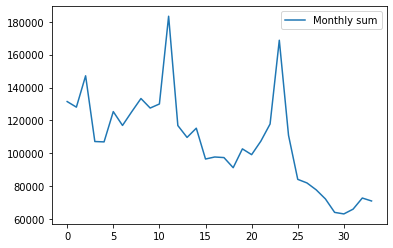

In [ ]:
train_by_item_id = train.pivot_table(index=['item_id'],values=['item_cnt_day'], 
                                        columns='date_block_num', aggfunc=np.sum, fill_value=0).reset_index()
train_by_item_id.columns = train_by_item_id.columns.droplevel().map(str)
train_by_item_id = train_by_item_id.reset_index(drop=True).rename_axis(None, axis=1)
train_by_item_id.columns.values[0] = 'item_id'
# print(train_by_item_id.sum()[1:])
train_by_item_id.sum()[1:].plot(legend=True, label="Monthly sum")

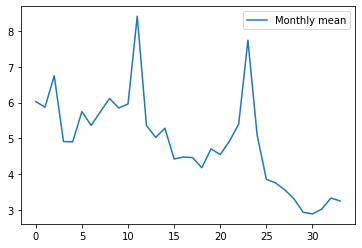

In [ ]:
train_by_item_id.mean()[1:].plot(legend=True, label="Monthly mean")

In [ ]:
train.item_id.nunique()

21807

In [ ]:
outdated_items = train_by_item_id[train_by_item_id.loc[:,'27':].sum(axis=1)==0] ##outdated after month 27 in our 34 month window
print('Outdated items:', len(outdated_items))

Outdated items: 12391


In [ ]:
print('Outdated items in test set:', len(test[test['item_id'].isin(outdated_items['item_id'])]))

Outdated items in test set: 6888


###Few other things you can observe/explore:
1. Neighbouring items in item_id are often quite similar. (items with id 1000 and 1001 could be somehow similar - genre, type, release date)
2. Recent sales 
3. Release Date

### Insights:
1. There are no missing values at all. (so far)
2. Number of sold items usually declines over the year. 
3. There are peaks in December and similar item count zig-zag behavior can be seen in June-July-August. This can be due to these periods being vacation time or possibly a [national holiday](https://en.wikipedia.org/wiki/Public_holidays_in_Russia).
4. 12391 of 21807 items in the train set are outdated since the last 6 months, which is quite huge, to say the least. 
5. Now, in the test set: 6888 outdated.

###shop_id based EDA:

In [ ]:
train_by_shop_id = train.pivot_table(index=['shop_id'],values=['item_cnt_day'], 
                                        columns='date_block_num', aggfunc=np.sum, fill_value=0).reset_index()
train_by_shop_id.columns = train_by_shop_id.columns.droplevel().map(str)
train_by_shop_id = train_by_shop_id.reset_index(drop=True).rename_axis(None, axis=1)
train_by_shop_id.columns.values[0] = 'shop_id'

for i in range(6,34):
    print('Does not exist in month',i,train_by_shop_id['shop_id'][train_by_shop_id.loc[:,'0':str(i)].sum(axis=1)==0].unique())

for i in range(6,28):
    print('Shop is outdated for month',i,train_by_shop_id['shop_id'][train_by_shop_id.loc[:,str(i):].sum(axis=1)==0].unique())

Does not exist in month 6 [ 9 11 20 33 34 36 39 40 48 49]
Does not exist in month 7 [ 9 11 20 33 34 36 39 40 48 49]
Does not exist in month 8 [ 9 11 20 33 34 36 39 40 48 49]
Does not exist in month 9 [11 20 33 34 36 39 40 48 49]
Does not exist in month 10 [11 20 33 34 36 39 40 48 49]
Does not exist in month 11 [11 20 33 34 36 39 40 48]
Does not exist in month 12 [11 20 33 34 36 39 40 48]
Does not exist in month 13 [11 20 33 34 36 39 40 48]
Does not exist in month 14 [11 20 33 34 36 48]
Does not exist in month 15 [11 20 33 34 36]
Does not exist in month 16 [11 20 33 34 36]
Does not exist in month 17 [11 20 33 34 36]
Does not exist in month 18 [11 20 33 36]
Does not exist in month 19 [11 20 36]
Does not exist in month 20 [11 20 36]
Does not exist in month 21 [11 36]
Does not exist in month 22 [11 36]
Does not exist in month 23 [11 36]
Does not exist in month 24 [11 36]
Does not exist in month 25 [36]
Does not exist in month 26 [36]
Does not exist in month 27 [36]
Does not exist in month 

In [ ]:
print('Recently opened shop items:', len(test[test['shop_id']==36])) ## note that this is from the test dataset

Recently opened shop items: 5100


###Few other things you can observe/explore:
1. When the shop was opened, i.e the opening month and when it got closed, i.e, the closing month
2. When the shop doesn't have sales

Possible things you can do with 'Date':

1. Whether it's holiday season or vacation - when sales are shown to be at peak
2. Month Number, or value of date_block_num//12 for seasonal items 


**Another observation**: With a close look we can find out that some shops have duplicated id/name - probably it changed location (within commercial center), or it has a different type (isle sale point), so think about what you can do with it?  (you can try and merge them)

##Data Preprocessing:
1. We can drop the text features since we are not using them in our prediction/not of relevance. 
2. We are asked to predict total sales for every product and store in the next month, and our data is given by day, so let's remove unwanted columns and aggregate the data by month.

In [ ]:
#selecting only useful features
train_monthly = lk_train[['date', 'date_block_num', 'shop_id', 'item_category_id', 'item_id', 'item_price', 'item_cnt_day']]

In [ ]:
# Group by month in this case "date_block_num" and aggregate features.
train_monthly = train_monthly.sort_values(['date']).groupby(['date_block_num', 'shop_id', 'item_category_id', 'item_id'], as_index=False)
train_monthly = train_monthly.agg({'item_price':['sum', 'mean'], 'item_cnt_day':['sum', 'mean','count']})
# Rename features.
train_monthly.columns = ['date_block_num', 'shop_id', 'item_category_id', 'item_id', 'item_price', 'mean_item_price', 'item_cnt', 'mean_item_cnt', 'transactions']

We're using empty_df, the idea is that we need a df that will have all combinations of months, shop_id, and item_id, so I first create an empty df, then iterate over the existing records to fill it, and finally fill the missing values with 0. We're taking all possible combinations here since we have to tell the model that for those months the item count for a particular shop ID/item ID was zero instead of having any missing records.

In [ ]:
# Build a data set with all the possible combinations of ['date_block_num','shop_id','item_id'] so we won't have missing records.
shop_ids = train_monthly['shop_id'].unique()
item_ids = train_monthly['item_id'].unique()
empty_df = []
for i in range(34):
    for shop in shop_ids:
        for item in item_ids:
            empty_df.append([i, shop, item])
    
empty_df = pd.DataFrame(empty_df, columns=['date_block_num','shop_id','item_id'])

In [ ]:
 #Merge the train set with the complete set (missing records will be filled with 0).
train_monthly = pd.merge(empty_df, train_monthly, on=['date_block_num','shop_id','item_id'], how='left')
train_monthly.fillna(0, inplace=True)


In [ ]:
train_monthly.head()

,date_block_num,shop_id,item_id,item_category_id,item_price,mean_item_price,item_cnt,mean_item_cnt,transactions
0,0,2,5572,2.0,10730.00,1532.857143,9.0,1.285714,7.0
1,0,2,5643,2.0,4775.21,2387.605000,0.0,0.000000,2.0
2,0,2,5583,5.0,1188.30,594.150000,2.0,1.000000,2.0
3,0,2,7893,6.0,5970.00,1990.000000,3.0,1.000000,3.0
4,0,2,7894,6.0,1490.00,1490.000000,1.0,1.000000,1.0


In [ ]:
train_monthly.describe()

,date_block_num,shop_id,item_id,item_category_id,item_price,mean_item_price,item_cnt,mean_item_cnt,transactions
count,6.734448e+06,6.734448e+06,6.734448e+06,6.734448e+06,6.734448e+06,6.734448e+06,6.734448e+06,6.734448e+06,6.734448e+06
mean,1.650000e+01,3.164286e+01,1.104189e+04,3.786271e+00,1.873922e+02,8.123012e+01,2.402225e-01,9.729913e-02,1.818165e-01
std,9.810709e+00,1.756189e+01,6.210744e+03,1.321296e+01,2.177442e+03,5.347327e+02,3.456639e+00,6.122031e-01,9.047315e-01
min,0.000000e+00,2.000000e+00,3.000000e+01,0.000000e+00,0.000000e+00,0.000000e+00,-4.000000e+00,-2.000000e+00,0.000000e+00
25%,8.000000e+00,1.600000e+01,5.385250e+03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,1.650000e+01,3.450000e+01,1.126550e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,2.500000e+01,4.700000e+01,1.606825e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,3.300000e+01,5.900000e+01,2.216700e+04,8.300000e+01,5.155736e+05,4.299000e+04,2.253000e+03,1.000000e+03,3.100000e+01


In [ ]:
# Extract time based features, this will be essential when we group the data based on month/year.
train_monthly['year'] = train_monthly['date_block_num'].apply(lambda x: ((x//12) + 2013))
train_monthly['month'] = train_monthly['date_block_num'].apply(lambda x: (x % 12))

In [ ]:
##date_block_num covers a window of 34 months and takes values from 0 to 33, so to extract some 'monthly' features
gp_month_mean = train_monthly.groupby(['month'], as_index=False)['item_cnt'].mean()
gp_month_sum = train_monthly.groupby(['month'], as_index=False)['item_cnt'].sum()
gp_category_mean = train_monthly.groupby(['item_category_id'], as_index=False)['item_cnt'].mean()
gp_category_sum = train_monthly.groupby(['item_category_id'], as_index=False)['item_cnt'].sum()
gp_shop_mean = train_monthly.groupby(['shop_id'], as_index=False)['item_cnt'].mean()
gp_shop_sum = train_monthly.groupby(['shop_id'], as_index=False)['item_cnt'].sum()

###Mean Item Count Per Month

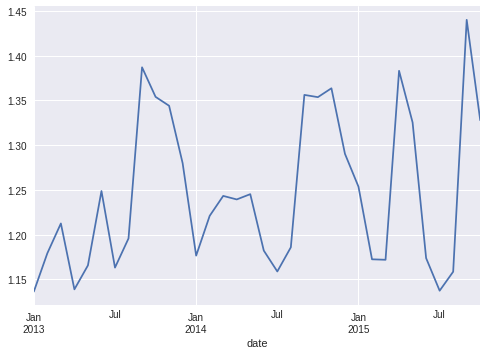

In [ ]:
plt.style.use('seaborn')
train.copy().set_index('date').item_cnt_day.resample('M') \
                            .mean().plot();

There are minimas during the months of July and January, maximas in October and December. 

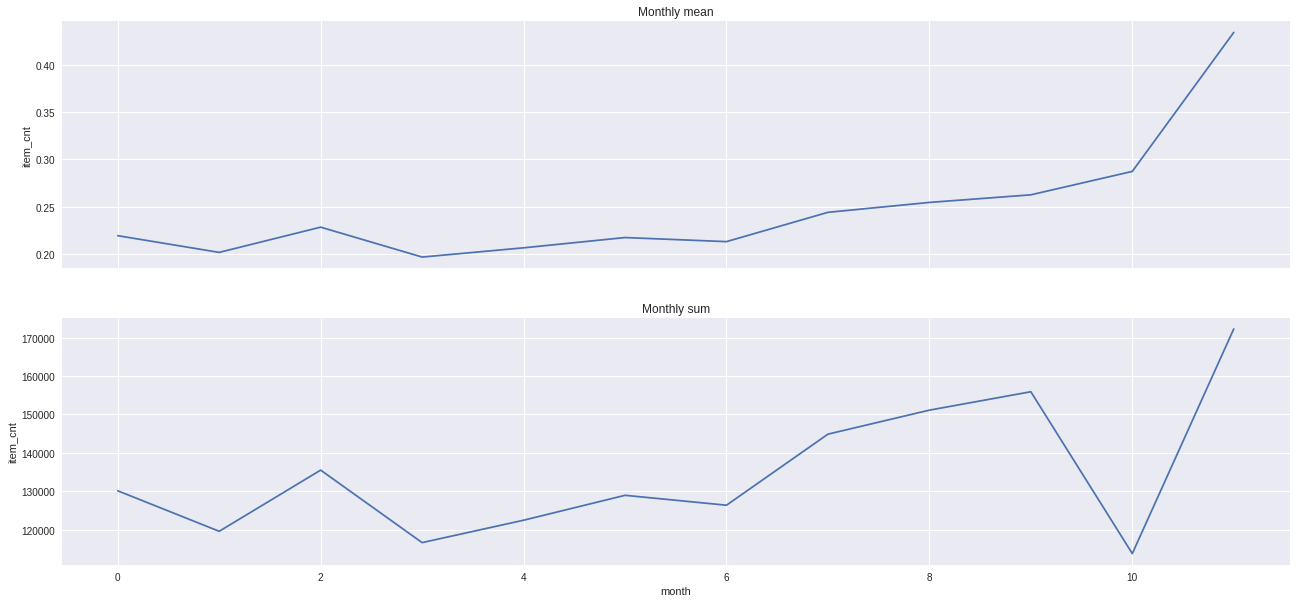

In [ ]:
f, axes = plt.subplots(2, 1, figsize=(22, 10), sharex=True)
sns.lineplot(x="month", y="item_cnt", data=gp_month_mean, ax=axes[0]).set_title("Monthly mean")
sns.lineplot(x="month", y="item_cnt", data=gp_month_sum, ax=axes[1]).set_title("Monthly sum")
plt.show()

1. As we can see we have a trending increase of item sales count (mean) towards the ending of the year.
2. There are peaks in October, then dips in November, followed by an increase in December and similar item count zig-zag behavior can be seen in June-July-August. This can be due to: vacation time/national holidays.
3. We can also try and create a Boolean holiday feature.  


###Which category sells more?

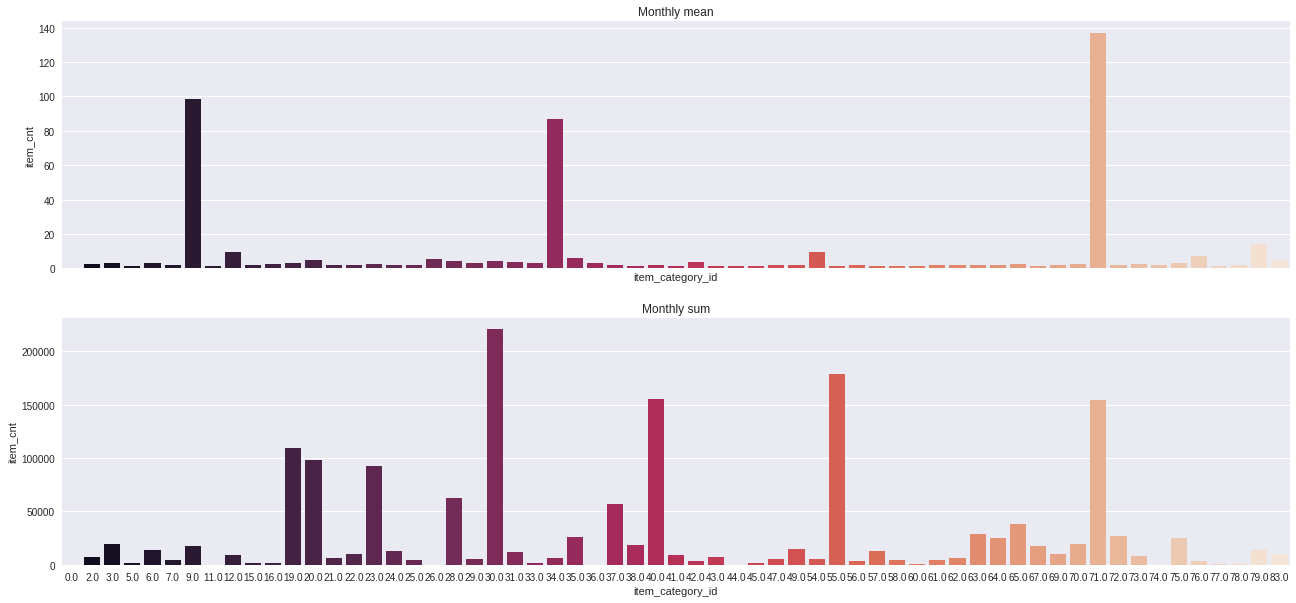

In [ ]:
f, axes = plt.subplots(2, 1, figsize=(22, 10), sharex=True)
sns.barplot(x="item_category_id", y="item_cnt", data=gp_category_mean, ax=axes[0], palette="rocket").set_title("Monthly mean")
sns.barplot(x="item_category_id", y="item_cnt", data=gp_category_sum, ax=axes[1], palette="rocket").set_title("Monthly sum")
plt.show()

Few of the categories are dominating the market. 

###Which shop sold out more?

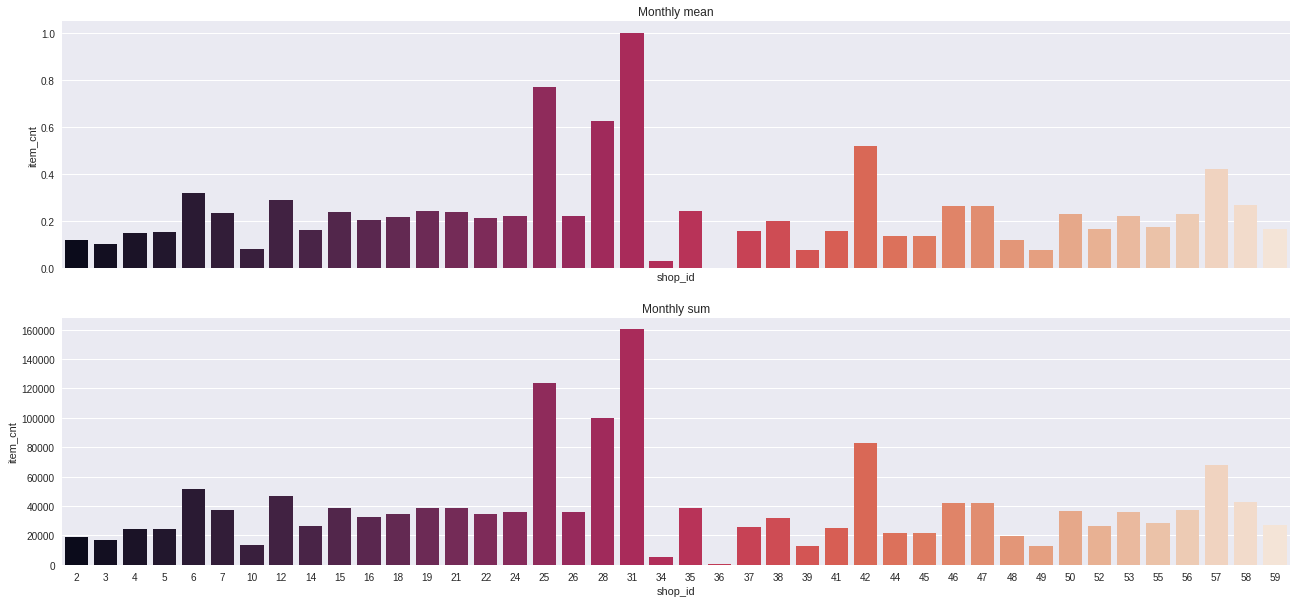

In [ ]:
f, axes = plt.subplots(2, 1, figsize=(22, 10), sharex=True)
sns.barplot(x="shop_id", y="item_cnt", data=gp_shop_mean, ax=axes[0], palette="rocket").set_title("Monthly mean")
sns.barplot(x="shop_id", y="item_cnt", data=gp_shop_sum, ax=axes[1], palette="rocket").set_title("Monthly sum")
plt.show()

Most of the shops have a similar sell rate, but 3 of them have a much higher rate, this may be cause of the shop size. 

An essential part of data preprocessing is identifying the outliers. Outliers must be located and eliminated since this data can skew your results due to erroneous data as well as exceptional data. So, let's try and identify them using a boxplot.

Now, identifying the outliers in another way compared to the one we've seen already.

Item Sale outliers: [ 8057 20949  9242 19437  3731 11373  9249  9248]
Item price outliers: [11365  6066 13199]


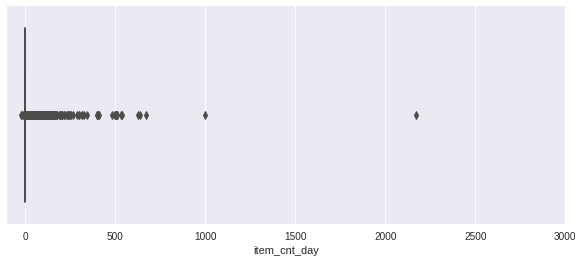

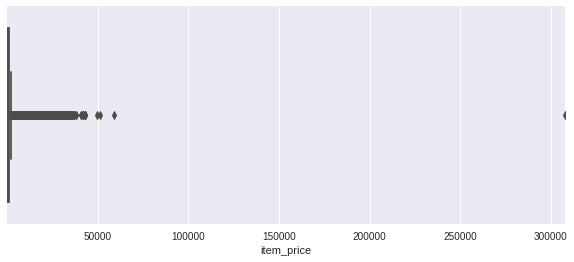

In [ ]:
plt.figure(figsize=(10,4))
plt.xlim(-100, 3000)
sns.boxplot(x=train['item_cnt_day'])
print('Item Sale outliers:',train['item_id'][train['item_cnt_day']>500].unique())

plt.figure(figsize=(10,4))
plt.xlim(train['item_price'].min(), train['item_price'].max())
sns.boxplot(x=train['item_price'])
print('Item price outliers:',train['item_id'][train['item_price']>50000].unique())

Another way of identifying the outliers:

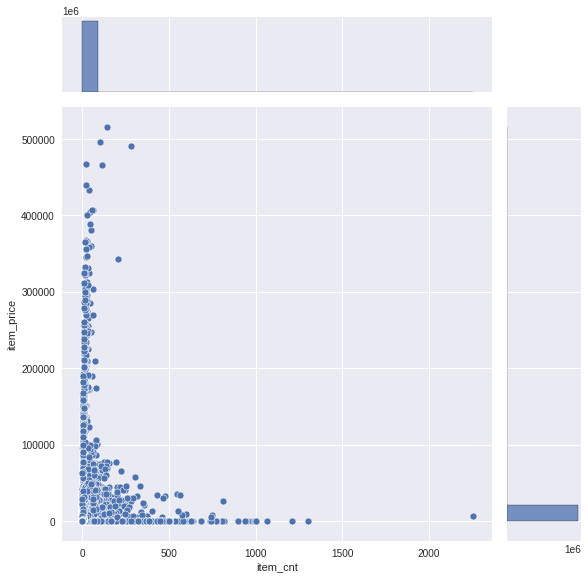

In [ ]:
sns.jointplot(x="item_cnt", y="item_price", data=train_monthly, height=8)
plt.show()

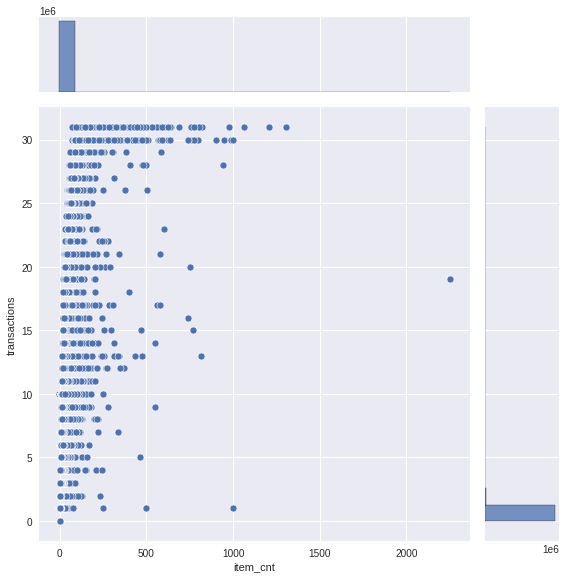

In [ ]:
sns.jointplot(x="item_cnt", y="transactions", data=train_monthly, height=8)
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


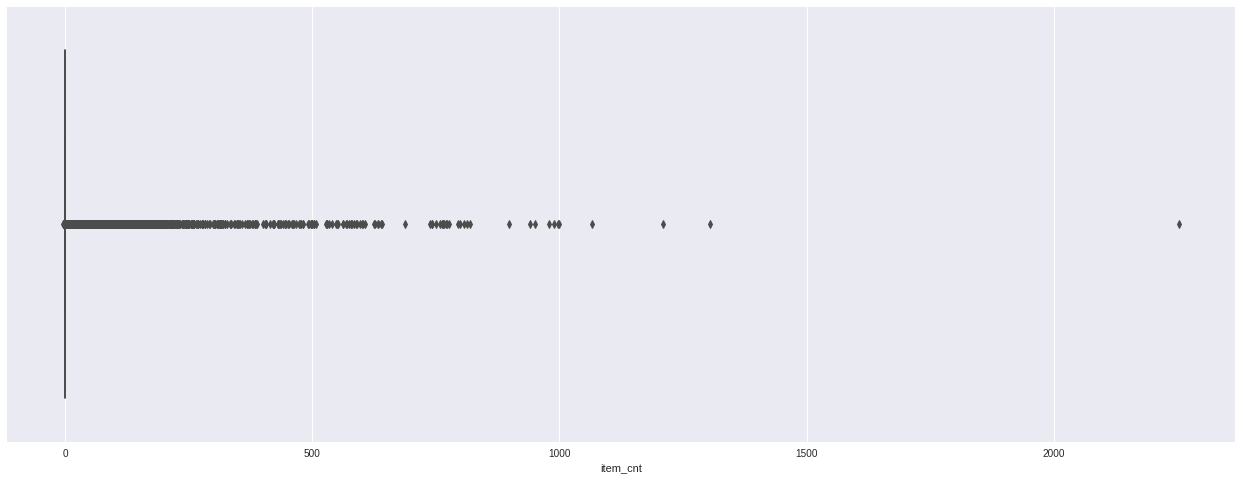

In [ ]:
plt.subplots(figsize=(22, 8))
sns.boxplot(train_monthly['item_cnt'])
plt.show()

Now, let's drop the outliers. In the above case for identifying outliers, we took 500 as our cutoff for item_cnt, you can do the same here. 

In [ ]:
train_monthly = train_monthly.query('item_cnt >= 0 and item_cnt <= 500 and item_price < 50000')
train_monthly

,date_block_num,shop_id,item_id,item_category_id,item_price,mean_item_price,item_cnt,mean_item_cnt,transactions,year,month
0,0,2,5572,2.0,10730.00,1532.857143,9.0,1.285714,7.0,2013,0
1,0,2,5643,2.0,4775.21,2387.605000,0.0,0.000000,2.0,2013,0
2,0,2,5583,5.0,1188.30,594.150000,2.0,1.000000,2.0,2013,0
3,0,2,7893,6.0,5970.00,1990.000000,3.0,1.000000,3.0,2013,0
4,0,2,7894,6.0,1490.00,1490.000000,1.0,1.000000,1.0,2013,0
...,...,...,...,...,...,...,...,...,...,...,...
6734443,33,36,9103,0.0,0.00,0.000000,0.0,0.000000,0.0,2015,9
6734444,33,36,9107,0.0,0.00,0.000000,0.0,0.000000,0.0,2015,9
6734445,33,36,5704,0.0,0.00,0.000000,0.0,0.000000,0.0,2015,9
6734446,33,36,12733,0.0,0.00,0.000000,0.0,0.000000,0.0,2015,9


##Feature Engineering:

Our label will be the "item_cnt" of the next month, as we are dealing with a forecast problem.

In [ ]:
train_monthly['item_cnt_month'] = train_monthly.sort_values('date_block_num').groupby(['shop_id', 'item_id'])['item_cnt'].shift(-1) ##since it's a forecast problem
train_monthly

,date_block_num,shop_id,item_id,item_category_id,item_price,mean_item_price,item_cnt,mean_item_cnt,transactions,year,month,item_cnt_month
0,0,2,5572,2.0,10730.00,1532.857143,9.0,1.285714,7.0,2013,0,1.0
1,0,2,5643,2.0,4775.21,2387.605000,0.0,0.000000,2.0,2013,0,0.0
2,0,2,5583,5.0,1188.30,594.150000,2.0,1.000000,2.0,2013,0,1.0
3,0,2,7893,6.0,5970.00,1990.000000,3.0,1.000000,3.0,2013,0,2.0
4,0,2,7894,6.0,1490.00,1490.000000,1.0,1.000000,1.0,2013,0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...
6734443,33,36,9103,0.0,0.00,0.000000,0.0,0.000000,0.0,2015,9,NaN
6734444,33,36,9107,0.0,0.00,0.000000,0.0,0.000000,0.0,2015,9,NaN
6734445,33,36,5704,0.0,0.00,0.000000,0.0,0.000000,0.0,2015,9,NaN
6734446,33,36,12733,0.0,0.00,0.000000,0.0,0.000000,0.0,2015,9,NaN


Unitary item prices.

In [ ]:
train_monthly['item_price_unit'] = train_monthly['item_price'] // train_monthly['item_cnt']
train_monthly['item_price_unit'].fillna(0, inplace=True)

Group based features.

First, we're grouping data using item_id.

In [ ]:
gp_item_price = train_monthly.sort_values('date_block_num').groupby(['item_id'], as_index=False).agg({'item_price':[np.min, np.max]})
gp_item_price.columns = ['item_id', 'hist_min_item_price', 'hist_max_item_price']

train_monthly = pd.merge(train_monthly, gp_item_price, on='item_id', how='left')

In [ ]:
train_monthly['price_increase'] = train_monthly['item_price'] - train_monthly['hist_min_item_price']
train_monthly['price_decrease'] = train_monthly['hist_max_item_price'] - train_monthly['item_price']

Rolling is a very useful operation for time series data. Rolling means creating a rolling window with a specified size and perform calculations on the data in this window which, of course, rolls through the data. The figure below explains the concept of rolling.

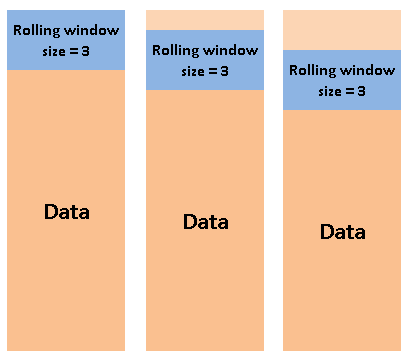

**Rolling Window**:

A rolling window model involves calculating a statistic on a fixed contiguous block of prior observations and using it as a forecast.

It may be more useful on time series problems where recent lag values are more predictive than older lag values. Like in this dataset, recent sales might be more useful in predicting the sales for November, so we use it. 

The rolling() function lets us perform rolling window functions on time series data. rolling() function can be called on both series and dataframe in pandas. It accepts window size as a parameter to group values by that window size and returns Rolling objects which have grouped values according to window size.

It is worth noting that the calculation starts when the whole window is in the data. In other words, if the size of the window is three, the first aggregation is done at the third row.

For further reference: https://in.mathworks.com/help/econ/rolling-window-estimation-of-state-space-models.html#buhfn65-1

In [ ]:
# Min value
f_min = lambda x: x.rolling(window=3, min_periods=1).min()
# Max value
f_max = lambda x: x.rolling(window=3, min_periods=1).max()
# Mean value
f_mean = lambda x: x.rolling(window=3, min_periods=1).mean()
# Standard deviation
f_std = lambda x: x.rolling(window=3, min_periods=1).std()

In [ ]:
function_list = [f_min, f_max, f_mean, f_std]
function_name = ['min', 'max', 'mean', 'std']

for i in range(len(function_list)):
    train_monthly[('item_cnt_%s' % function_name[i])] = train_monthly.sort_values('date_block_num').groupby(['shop_id', 'item_category_id', 'item_id'])['item_cnt'].apply(function_list[i])

# Fill the empty std features with 0
train_monthly['item_cnt_std'].fillna(0, inplace=True)


**Lag based features**:

A lag features is a fancy name for a variable (in our case the target variable) which contains data from prior time steps.

Lag features are a classical way of transforming a time series forecasting problem into a supervised learning problem.

Let's say you are predicting the stock price for a company. So, the previous day’s stock price is vital in making predictions right? So, this means that the value at time t is greatly affected by the value at time t-1. The past values are known as lags, so t-1 is lag 1, t-2 is lag 2, and so on.

In [ ]:
lag_list = [1, 2, 3]

for lag in lag_list:
    ft_name = ('item_cnt_shifted%s' % lag)
    train_monthly[ft_name] = train_monthly.sort_values('date_block_num').groupby(['shop_id', 'item_category_id', 'item_id'])['item_cnt'].shift(lag)
    # Fill the empty shifted features with 0
    train_monthly[ft_name].fillna(0, inplace=True)

In [ ]:
train_monthly['item_trend'] = train_monthly['item_cnt']

for lag in lag_list:
    ft_name = ('item_cnt_shifted%s' % lag)
    train_monthly['item_trend'] -= train_monthly[ft_name]

train_monthly['item_trend'] /= len(lag_list) + 1

In [ ]:
train_monthly.head().T

,0,1,2,3,4
date_block_num,0.000000,0.000,0.00,0.00,0.00
shop_id,2.000000,2.000,2.00,2.00,2.00
item_id,5572.000000,5643.000,5583.00,7893.00,7894.00
item_category_id,2.000000,2.000,5.00,6.00,6.00
item_price,10730.000000,4775.210,1188.30,5970.00,1490.00
mean_item_price,1532.857143,2387.605,594.15,1990.00,1490.00
item_cnt,9.000000,0.000,2.00,3.00,1.00
mean_item_cnt,1.285714,0.000,1.00,1.00,1.00
transactions,7.000000,2.000,2.00,3.00,1.00
year,2013.000000,2013.000,2013.00,2013.00,2013.00


Since this is a time series dataset so we have to pre-define which data can be used for train and test.


As we know the test set is in the future, so we should try to simulate the same distribution on our train/validation split.

Our train set will be the first 3-27 blocks, validation will be last 5 blocks (28-32) and test will be block 33.

We can leave out the first 3 months because we use a 3 month window to generate features, so these first 3 month won't have really windowed useful features.




In [ ]:
train_set = train_monthly.query('date_block_num >= 3 and date_block_num < 28').copy()
validation_set = train_monthly.query('date_block_num >= 28 and date_block_num < 33').copy()
test_set = train_monthly.query('date_block_num == 33').copy()

train_set.dropna(subset=['item_cnt_month'], inplace=True)
validation_set.dropna(subset=['item_cnt_month'], inplace=True)

train_set.dropna(inplace=True)
validation_set.dropna(inplace=True)

print('Train set records:', train_set.shape[0])
print('Validation set records:', validation_set.shape[0])
print('Test set records:', test_set.shape[0])

print('Train set records: %s (%.f%% of complete data)' % (train_set.shape[0], ((train_set.shape[0]/train_monthly.shape[0])*100)))
print('Validation set records: %s (%.f%% of complete data)' % (validation_set.shape[0], ((validation_set.shape[0]/train_monthly.shape[0])*100)))

Train set records: 4946203
Validation set records: 989203
Test set records: 197833
Train set records: 4946203 (74% of complete data)
Validation set records: 989203 (15% of complete data)


Mean encoding can be quite helpful for the model which we use (a gradient boosting model), and represent the features in a better way. Since we have a lot of different values for shop_ids, item_ids, this can also help in reducing cardinality. 

https://towardsdatascience.com/why-you-should-try-mean-encoding-17057262cd0

In [ ]:
# Shop mean encoding.
gp_shop_mean = train_set.groupby(['shop_id']).agg({'item_cnt_month': ['mean']})
gp_shop_mean.columns = ['shop_mean']
gp_shop_mean.reset_index(inplace=True)
# Item mean encoding.
gp_item_mean = train_set.groupby(['item_id']).agg({'item_cnt_month': ['mean']})
gp_item_mean.columns = ['item_mean']
gp_item_mean.reset_index(inplace=True)
# Shop with item mean encoding.
gp_shop_item_mean = train_set.groupby(['shop_id', 'item_id']).agg({'item_cnt_month': ['mean']})
gp_shop_item_mean.columns = ['shop_item_mean']
gp_shop_item_mean.reset_index(inplace=True)
# Year mean encoding.
gp_year_mean = train_set.groupby(['year']).agg({'item_cnt_month': ['mean']})
gp_year_mean.columns = ['year_mean']
gp_year_mean.reset_index(inplace=True)
# Month mean encoding.
gp_month_mean = train_set.groupby(['month']).agg({'item_cnt_month': ['mean']})
gp_month_mean.columns = ['month_mean']
gp_month_mean.reset_index(inplace=True)

In [ ]:
# Add mean encoding features to train set.
train_set = pd.merge(train_set, gp_shop_mean, on=['shop_id'], how='left')
train_set = pd.merge(train_set, gp_item_mean, on=['item_id'], how='left')
train_set = pd.merge(train_set, gp_shop_item_mean, on=['shop_id', 'item_id'], how='left')
train_set = pd.merge(train_set, gp_year_mean, on=['year'], how='left')
train_set = pd.merge(train_set, gp_month_mean, on=['month'], how='left')
# Add mean encoding features to validation set.
validation_set = pd.merge(validation_set, gp_shop_mean, on=['shop_id'], how='left')
validation_set = pd.merge(validation_set, gp_item_mean, on=['item_id'], how='left')
validation_set = pd.merge(validation_set, gp_shop_item_mean, on=['shop_id', 'item_id'], how='left')
validation_set = pd.merge(validation_set, gp_year_mean, on=['year'], how='left')
validation_set = pd.merge(validation_set, gp_month_mean, on=['month'], how='left')

In [ ]:
# Create train and validation sets and labels. 
X_train = train_set.drop(['item_cnt_month', 'date_block_num'], axis=1)
Y_train = train_set['item_cnt_month'].astype(int)
X_validation = validation_set.drop(['item_cnt_month', 'date_block_num'], axis=1)
Y_validation = validation_set['item_cnt_month'].astype(int)

In [ ]:
latest_records = pd.concat([train_set, validation_set]).drop_duplicates(subset=['shop_id', 'item_id'], keep='last')
X_test = pd.merge(test, latest_records, on=['shop_id', 'item_id'], how='left', suffixes=['', '_'])
X_test['year'] = 2015
X_test['month'] = 9
X_test.drop('item_cnt_month', axis=1, inplace=True)
X_test = X_test[X_train.columns]

In [ ]:
sets = [X_train, X_validation, X_test]

# This was taking too long.
# Replace missing values with the median of each item.
# for dataset in sets:
#     for item_id in dataset['item_id'].unique():
#         for column in dataset.columns:
#             item_median = dataset[(dataset['item_id'] == item_id)][column].median()
#             dataset.loc[(dataset[column].isnull()) & (dataset['item_id'] == item_id), column] = item_median

# Replace missing values with the median of each shop.            
for dataset in sets:
    for shop_id in dataset['shop_id'].unique():
        for column in dataset.columns:
            shop_median = dataset[(dataset['shop_id'] == shop_id)][column].median()
            dataset.loc[(dataset[column].isnull()) & (dataset['shop_id'] == shop_id), column] = shop_median
            
# Fill remaining missing values on test set with mean.
X_test.fillna(X_test.mean(), inplace=True)

In [ ]:
# I'm dropping "item_category_id", we don't have it on test set and would be a little hard to create categories for items that exist only on test set.
X_train.drop(['item_category_id'], axis=1, inplace=True)
X_validation.drop(['item_category_id'], axis=1, inplace=True)
X_test.drop(['item_category_id'], axis=1, inplace=True)

In [ ]:
X_test.head().T

,0,1,2,3,4
shop_id,5.000000,5.000000,5.000000,5.000000,5.000000
item_id,5037.000000,5320.000000,5233.000000,5232.000000,5268.000000
item_price,749.500000,0.000000,2997.000000,0.000000,0.000000
mean_item_price,749.500000,0.000000,999.000000,0.000000,0.000000
item_cnt,1.000000,0.000000,3.000000,0.000000,0.000000
mean_item_cnt,1.000000,0.000000,1.000000,0.000000,0.000000
transactions,1.000000,0.000000,3.000000,0.000000,0.000000
year,2015.000000,2015.000000,2015.000000,2015.000000,2015.000000
month,9.000000,9.000000,9.000000,9.000000,9.000000
item_price_unit,749.000000,0.000000,999.000000,0.000000,0.000000


##Model we can use:

####XGBoost:
Read more here: [XGBoost](https://towardsdatascience.com/https-medium-com-vishalmorde-xgboost-algorithm-long-she-may-rein-edd9f99be63d)

In [ ]:
# Use only part of features on XGBoost.
xgb_features = ['item_cnt','item_cnt_mean', 'item_cnt_std', 'item_cnt_shifted1', 
                'item_cnt_shifted2', 'item_cnt_shifted3', 'shop_mean', 
                'shop_item_mean', 'item_trend', 'mean_item_cnt']
xgb_train = X_train[xgb_features]
xgb_val = X_validation[xgb_features]
xgb_test = X_test[xgb_features]

In [ ]:
xgb_model = XGBRegressor(max_depth=8, 
                         n_estimators=500, 
                         min_child_weight=1000,  
                         colsample_bytree=0.7, 
                         subsample=0.7, 
                         eta=0.3, 
                         seed=0)
xgb_model.fit(xgb_train, 
              Y_train, 
              eval_metric="rmse", 
              eval_set=[(xgb_train, Y_train), (xgb_val, Y_validation)], 
              verbose=20, 
              early_stopping_rounds=20)

[19:48:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:48:16] WARNING: /workspace/src/learner.cc:686: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
[0]	validation_0-rmse:0.934429	validation_1-rmse:0.926272
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[20]	validation_0-rmse:0.680001	validation_1-rmse:0.797156
Stopping. Best iteration:
[19]	validation_0-rmse:0.681216	validation_1-rmse:0.796756



XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, eta=0.3, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=8, min_child_weight=1000, missing=None, n_estimators=500,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=0, silent=None,
             subsample=0.7, verbosity=1)

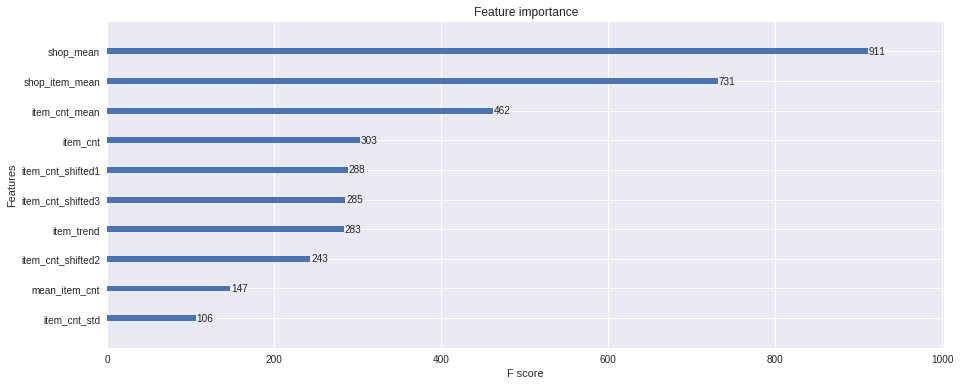

In [ ]:
plt.rcParams["figure.figsize"] = (15, 6)
plot_importance(xgb_model)
plt.show()

In [ ]:
xgb_train_pred = xgb_model.predict(xgb_train)
xgb_val_pred = xgb_model.predict(xgb_val)
xgb_test_pred = xgb_model.predict(xgb_test)

In [ ]:
print('Train rmse:', np.sqrt(mean_squared_error(Y_train, xgb_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_validation, xgb_val_pred)))

Train rmse: 0.6850136917214753
Validation rmse: 0.79782707613725


In [ ]:
## for making the final predictions: 
# prediction_df = pd.DataFrame(test['ID'], columns=['ID'])
# prediction_df['item_cnt_month'] = final_predictions.clip(0., 20.)
# prediction_df.to_csv('submission.csv', index=False)
# prediction_df.head(10)

##Time Series Forcasting: 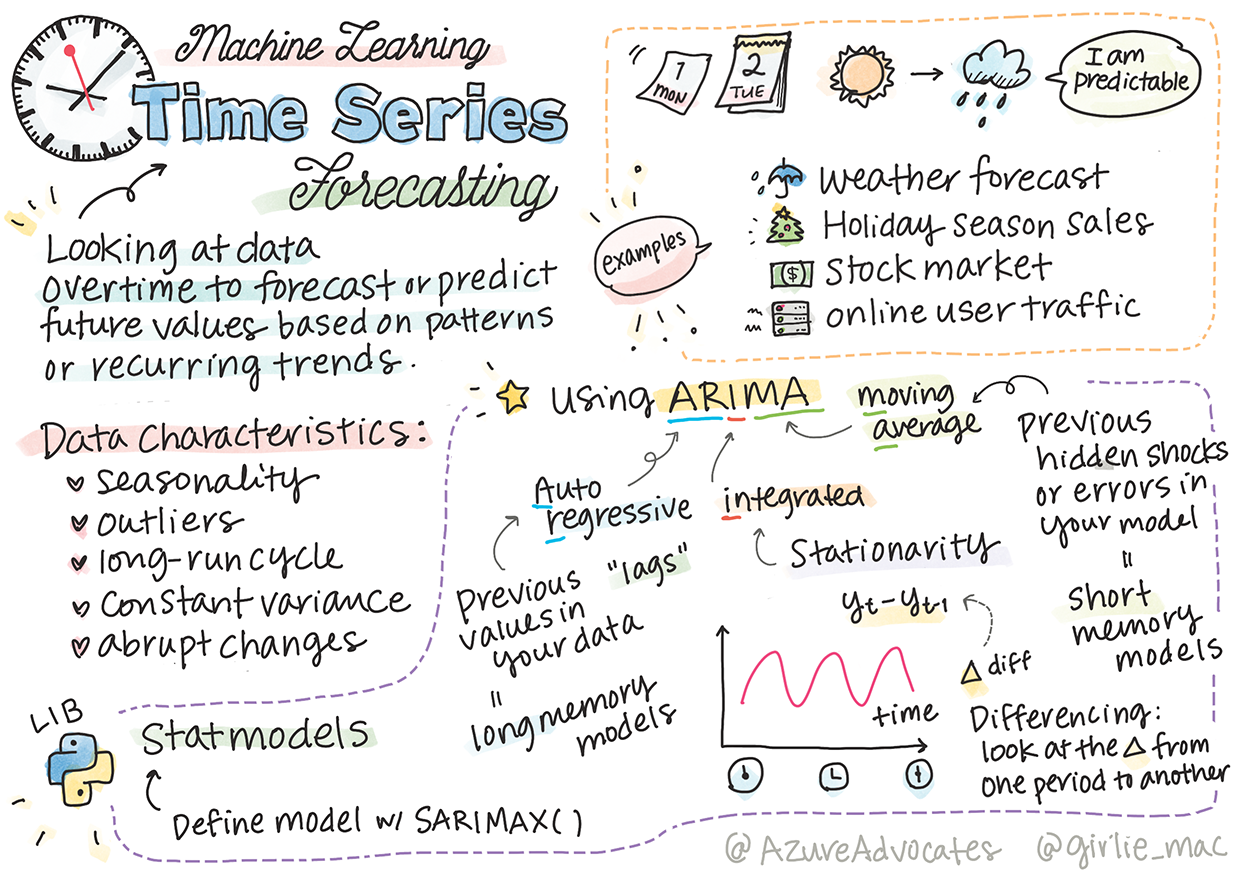

##Further references:

1.[Rolling, Shifting](https://towardsdatascience.com/time-series-analysis-resampling-shifting-and-rolling-f5664ddef77e)

2.[Basic feature engineering for time-series data](https://machinelearningmastery.com/basic-feature-engineering-time-series-data-python/)

3.[Time-series functions](https://towardsdatascience.com/ultimate-pandas-guide-time-series-window-functions-a5362b782f3e)

4.[Rolling-window Regression](https://medium.com/making-sense-of-data/time-series-next-value-prediction-using-regression-over-a-rolling-window-228f0acae363)

5.[Microsoft ML for beginners: time series](https://github.com/microsoft/ML-For-Beginners/tree/main/7-TimeSeries)




###Alternative approaches you could try out: 
You can try any other Gradient Boosting framework too like lightGBM or CatBoost, or otherwise:

1. Heuristic Model: Using a rule-based algorithm/search, a heuristic function (algorithm) or simply a heuristic is a shortcut to solving a problem when there are no exact solutions for it or the time to obtain the solution is too long. A heuristic is normally a hand-coded function. It is not based on a model obtained by training on a data set.
[Heuristics v ML](https://towardsdatascience.com/when-not-to-use-machine-learning-14ec62daacd7)
2. Using LSTMs: [Solution using LSTMs](https://colab.research.google.com/drive/1qeJJJtrxxyXg7KGuamtk7CT7acKyR7V1?usp=sharing#scrollTo=k_r2sTYDU3UG)
3. Adverserial Validation: a method for selecting training examples most similar to test examples and using them as a validation set, also helps diagnose overfitting. [read up here](https://towardsdatascience.com/adversarial-validation-ca69303543cd)
4. Forecasting Models like ARIMA (although it's similar to this)
5. Stacking: it involves combining the predictions from multiple machine learning models on the same dataset, like bagging and boosting in the best possible way. 

## From How to Win a Data Science Competition course:


Week 1: Introduction and Recap
Competition Mechanics

Example of competition mechanics:

1. Analyze data
2. Fit model
3. Submit
4. See public score
5. Repeat 1-4

Platforms for competitions: Kaggle, DrivenData, CrowdAnalityx

Real World Application vs. Competitions

**Real world ML Pipeline:**

1. Understanding of business problem
2. Problem formalization
3. Data collecting
4. Data preprocessing
5. Modelling
6. Way to evaluate model in real life
7. Way to deploy model

**In competition:**

1. No problem formalization necessary
2. No need to choose target metric
3. No deployment issues

**Philosophy of competitions**

It's not only about ML algorithms. It's more about data and making things work, not about algorithms themselves. Everyone can and most people will use and fine-tune classic approaches.
          
Do not limit yourself.

It is ok to use
  1. Heuristics
  2. Manual data analysis

Do not be overwhelmed by
  1. Complex solutions
  2. Advanced feature engineering
        

Recap of main ML algorithms

Linear models

    Separating objects with a plane
    Examples:
        Logistic regression
        Support Vector Machines
    Good for sparse high-dimensional data
    Limitations:
        Sets of points that form rings for instance
    Libraries:
        Scikit learn
        Vowpal Wabbit: good for handling really large data sets

Tree-based methods

    Decision tree as a basic block for building more complicated models.
    Examples:
        Decision tree
        Random forest
        GBDT = Gradient Boosting Decision Trees
    Good default method for tabular data
    Libraries:
        Scikit learn (recommended for Random Forests)
        XGBoost (recommended for Gradient Boosting)
        Microsoft LightGBM (recommended for GB)

k-Nearest Neighbours

    Features based on nearest neighbours are often very informative.
    Library:
        Scikit learn (recommended)

Neural Networks

    Especially good for images, sounds, text and sequences.
    Libraries:
        TensorFlow
        PyTorch (recommended)
        MXNet
        Lasagne

When it comes to ML, there is no free lunch.

1. There is no method which outperforms all others for all tasks
2. For every method we can construct a task for which this particular method will not be the best

